# Examining walk length effect

## <font color="red"> Experiment description **Not updated from ex35!** </font>
### Narrative set-up
Recent results suggest that our current methodology is unable to reproduce the prior results utilizing only degree information (ex33v2.1, see [Reference Figure (1)](#ref-fig-1)). However, this does not rely on embedding information at all and hence, under logistic regression, should be able to reproduce prior "DC"-classifier results nearly exactly, up to very minor fluctuations due to random observations. Hence, we find ourselves needing to re-examine the fundamentals of our current workflow's reconstruction.

This experiment is a follow-up to EMB_ex34 which established the inconsistency of network size in current experiments and prior work is responsible for the observed performance discrepancies. See [Reference Figure (2)](#ref-fig-2) for an annotated figure illustrating this phenomena.

### Goal
The main goal of this experiment is to run an "all features" version of both our current LogReg-classifier and our previous "DC" classifier on the same LFR benchmarks to see if an exactly equivalent experimental setting is able to produce comparable results.

This is motivated by the results of EMB_ex34 suggesting that size discrepancies, originally enacted for speed with the slow embedding process, is the primary contributor to current performance discrepancies.


---
---

# Set-up

## Package management

In [2]:
# --- Standard library ---
import sys
import pickle
from enum import Enum
import random

# --- Scientific computing ---
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score

# --- Network science ---
from cdlib import algorithms
import networkx as nx
from node2vec import Node2Vec

# --- Data handling and visualization ---
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline

# --- Project source code ---
sys.path.append("../../src/")
from src.data.preprocessing import duplex_network  # handle overlap, inconsistent node sets
from src.data.benchmarks import generate_multiplex_configuration, lfr_multiplex  # benchmark samplers
from src.sampling.random import partial_information  # PFI observation
from src.classifiers.features import *  # degree feature calculations, label wrapper
from src.classifiers.logreg import *  # wrappers for scikit-learn logistic regression model functions

## Global config

In [3]:
# * Pathing aliases
_ROOT = "../../"
_DATA = _ROOT + "data/input/"
_DFS = _ROOT + "results/dataframes/"
_FIGS = _ROOT + "results/plots/"

In [14]:
# * Plotting parameters
custom_plot_settings = {
    # Figure config
    "figure.figsize": (8,6),
    "figure.frameon": True,
    "figure.autolayout": True,
    "axes.titlesize": 16,
    # Axes config
    "xtick.minor.size": 2,
    # Save-to-disk config
    "savefig.facecolor": "white",
    "savefig.transparent": False
}
mpl.rcParams.update(custom_plot_settings)

# * Plotting aliases
colors_ = ["black", "red", "blue", "green", "purple"]
markers_ = ["o", "s", "+", "^", "v"]
viridis_ = mpl.colormaps['viridis']

---

# Experiment

## Function set-up

In [5]:
def renormalize_embedding_per_component (G, n2v_emb):
    n2v_emb_rescaled = {}
    for n in G:
        n2v_emb_rescaled[n] = n2v_emb.wv[str(n)]

    nr_comp = 0
    components = nx.connected_components(G)
    for c in components:
        nr_comp += 1
        list_of_nodes = []
        norm = 0.0
        for n in c:
            list_of_nodes.append(n2v_emb_rescaled[n])
        cm = np.add.reduce(list_of_nodes) / float(len(list_of_nodes))
        for n in c:
            n2v_emb_rescaled[n] = n2v_emb_rescaled[n] - cm
            norm += np.linalg.norm(n2v_emb_rescaled[n])
        if norm > 0.0:
            for n in c:
                n2v_emb_rescaled[n] = n2v_emb_rescaled[n] / norm

    return n2v_emb_rescaled

## Data set-up

### Specify parameters

In [6]:
_DATA_DICT = {
    "N": "number of nodes (in shared node set)",
    "GAMMA": "degree exponent of power-law degree distribution (from sampled distribution, finite sampling effects may yield different exponent if re-fit)",
    "MU": "mixing parameter for LFR model. Smaller MU implies (and is implied by) stronger modular structure.",
    "KMIN": "minimum degree (in either layer)",
    "KMAX": "maximum degree (in either layer)",
    "AVG_K": "average degree (in both layers)",
    "T1": "equivalent to GAMMA for LFR models",
    "T2": "community size power-law distribution exponent",
    "PROB": "relabeling probability. Controls correlation, with 0->1 = correlated->uncorrelated",
    "SIGN": "degree sequence sorting. Couples with PROB to produce anti/directly correlated degree sequences. -1 => anticorrelated, 1 => correlated"
}

In [7]:
class NetworkParams(Enum):
    # Shared params
    N = 1_000
    PROB = 1.0
    GAMMA = 2.1
    KMAX = np.sqrt(1_000)
    # Configuration model params
    KMIN = 3
    SIGN = 1
    # LFR params
    AVG_K = 6.0
    T2 = 1.0
    MU = 0.1
    MIN_COMMUNITY = 1 # ignored

In [8]:
class ExperimentParams(Enum):
    THETAS = np.linspace(0.05, 0.95, 10, endpoint=True)

In [9]:
LOGREG = {"fit_intercept": True, "solver": "newton-cholesky", "penalty": None}

### Sample duplex

In [10]:
duplex, _, _, _ = lfr_multiplex(
    int(NetworkParams.N.value),  # number of nodes
    NetworkParams.GAMMA.value,  # degree distribution exponent
    NetworkParams.T2.value,  # community size distribution exponent
    NetworkParams.MU.value,  # community mixing parameter
    NetworkParams.AVG_K.value,  # average degree
    NetworkParams.KMAX.value,  # maximum degree
    NetworkParams.MIN_COMMUNITY.value,  # minimum community size (ignored)
    NetworkParams.PROB.value,  # degree sequence correlation
)

setting... -N 1000
setting... -k 6.0
setting... -maxk 31.622776601683793
setting... -t1 2.1
setting... -t2 1.0
setting... -mu 0.1

**************************************************************
number of nodes:	1000
average degree:	6
maximum degree:	32
exponent for the degree distribution:	2.1
exponent for the community size distribution:	1
mixing parameter:	0.1
number of overlapping nodes:	0
number of memberships of the overlapping nodes:	0
**************************************************************

-----------------------------------------------------------
community size range automatically set equal to [3 , 32]
it took too long to decide the memberships; I will try to change the community sizes
new community sizes
19 10 11 6 14 29 28 4 8 4 15 28 4 27 28 5 6 30 15 6 24 12 7 4 19 21 3 21 17 3 13 7 25 22 9 3 28 9 7 7 4 5 21 12 16 3 4 10 17 29 15 26 11 7 14 5 5 14 4 5 10 3 9 5 19 3 3 5 4 13 9 15 13 7 7 30 6 11 6 3 7 27 

it took too long to decide the memberships; I will try to cha

Segmentation fault


In [11]:
G, H = duplex_network(duplex, 1, 2, verbose=True)

Number of common edges removed: 13
Number of inactive nodes removed from layer 1: 0
Number of inactive nodes removed from layer 2: 0
Size of active node set union from layers 1 and 2: 2000


### Compute remnants

In [12]:
remnants = dict()  # theta -> [remnants infomation] mapping
for theta in ExperimentParams.THETAS.value:
    remnant_G, remnant_H, test_edges, train_edges = partial_information(G, H, theta)
    record = {
        "remnants": (remnant_G, remnant_H),
        "observed_edges": train_edges,
        "unobserved_edges": test_edges
    }
    remnants[theta] = record

## Feature calculation

In [13]:
features_labels_by_WL = dict()  # walk_length -> (features, labels)

In [14]:
for walk_length in np.linspace(5, 100, num=10, endpoint=True):
    features = dict()  # theta -> [train features, test features]
    labels = dict()  # theta -> [train labels, test labels]
    for theta, record in remnants.items():
        # --- Degree feature ---
        # Partially compute degree likelihood feature
        src_degrees_train, tgt_degrees_train = get_degrees(record["remnants"], list(record["observed_edges"].keys()))
        src_degrees_test, tgt_degrees_test = get_degrees(record["remnants"], list(record["unobserved_edges"].keys()))

        # Complete degree likelihood feature calculations
        feature_degrees_train = get_configuration_probabilities_feature(src_degrees_train, tgt_degrees_train)
        feature_degrees_test = get_configuration_probabilities_feature(src_degrees_test, tgt_degrees_test)

        # --- Embedding feature ---
        # & Embed remnants
        node2vec1 = Node2Vec(record["remnants"][0], dimensions=128, walk_length=walk_length, num_walks=10, workers=6)
        node2vec2 = Node2Vec(record["remnants"][1], dimensions=128, walk_length=walk_length, num_walks=10, workers=6)

        model1 = node2vec1.fit(window=10, min_count=1, batch_words=4)
        model2 = node2vec2.fit(window=10, min_count=1, batch_words=4)

        # & Align centers
        embeddings_G = renormalize_embedding_per_component(record["remnants"][0], model1)
        embeddings_H = renormalize_embedding_per_component(record["remnants"][1], model2)

        distances_G_train, distances_H_train = \
            get_distances((embeddings_G, embeddings_H), list(record["observed_edges"].keys()))
        distances_G_test, distances_H_test = \
            get_distances((embeddings_G, embeddings_H), list(record["unobserved_edges"].keys()))

        feature_distances_train = get_configuration_distances_feature(distances_G_train, distances_H_train, zde_penalty=0.1)
        feature_distances_test = get_configuration_distances_feature(distances_G_test, distances_H_test, zde_penalty=0.1)

        normalizer = max(
            np.abs(min(feature_distances_train)),
            np.abs(max(feature_distances_train)),
        )
        feature_distances_train = [x / normalizer for x in feature_distances_train]

        normalizer = max(
            np.abs(min(feature_distances_test)),
            np.abs(max(feature_distances_test)),
        )
        feature_distances_test = [x / normalizer for x in feature_distances_test]

        # --- Cleaning up features ---
        feature_matrix_train, feature_matrix_test = \
            format_feature_matrix(
                {"emb", "imb", "deg"},
                len(record["observed_edges"]), len(record["unobserved_edges"]),
                feature_distances_train, feature_distances_test,
                feature_degrees_train, feature_degrees_test
            )

        # --- Labels ---
        labels_train, labels_test = get_labels(record["observed_edges"], record["unobserved_edges"])

        # Save to feature and label mappings
        features[theta] = (feature_matrix_train, feature_matrix_test)
        labels[theta] = (labels_train, labels_test)

    # Group by walk_length
    features_labels_by_WL[walk_length] = (features, labels)

Generating walks (CPU: 3): 100%|██████████| 2/2 [00:06<00:00,  3.24s/it]


## Model training and evaluation

In [15]:
models_modelperfs_by_WL = dict()  # walk_length -> (models, model_performances)

In [16]:
for walk_length, (features, labels) in features_labels_by_WL.items():
    models = dict()  # theta -> [trained logistic regression]
    model_performances = dict()  # theta -> [performances]
    for theta in ExperimentParams.THETAS.value:
        # & Train model
        # Retrieve training features and labels
        X = features[theta][0]
        Y = labels[theta][0]

        # Train model
        model = train_fit_logreg(X, Y, LOGREG)

        # Save to models mapping
        models[theta] = model

        # & Test model
        # Retrieve testing features and labels labels
        X = features[theta][1]
        Y = labels[theta][1]

        # Apply model to test data
        model = models[theta]
        accuracy = get_model_accuracy(model, X, Y)
        auroc = get_model_auroc(model, X, Y)
        aupr = get_model_aupr(model, X, Y)
        performances = {
            "accuracy": accuracy,
            "auroc": auroc,
            "aupr": aupr,
        }

        # Save to models mapping
        model_performances[theta] = performances

    # Group by walk_length
    models_modelperfs_by_WL[walk_length] = (models, model_performances)

In [17]:
with open("logreg_by_walk-length.pkl", "wb") as _fh:
    pickle.dump(models_modelperfs_by_WL, _fh, pickle.HIGHEST_PROTOCOL)

---

# Analysis

In [5]:
with open("logreg_by_walk-length.pkl", "rb") as _fh:
    models_modelperfs_by_WL = pickle.load(_fh)

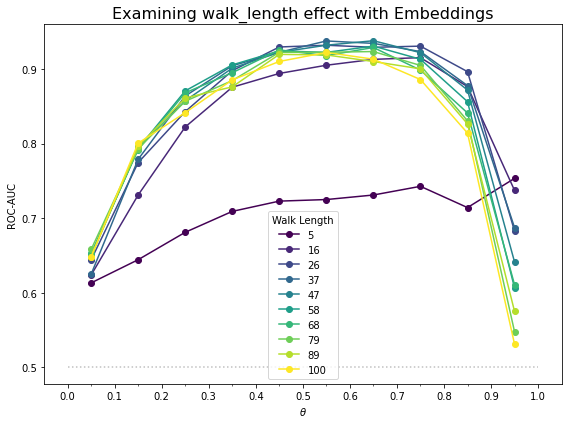

In [21]:
# Instantiate figure, subset relevant data
fig = plt.figure()

# Plotting data
X = sorted(ExperimentParams.THETAS.value)
idx = 0
for wl, (models, perfs) in models_modelperfs_by_WL.items():
    Y = [perf["auroc"] for perf in perfs.values()]
    plt.plot(
        X, Y,
        label=f"{wl:.0f}",
        color=viridis_(idx/(len(models_modelperfs_by_WL)-1)),
        marker="o"
    )
    idx += 1

plt.hlines(0.5, 0, 1, linestyles=":", color="gray", alpha=0.5)

# Axes configuration
ax = fig.axes[0]

plt.xticks(np.linspace(0, 1, 11))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))

plt.xlabel("$\\theta$")
plt.ylabel("ROC-AUC")

# Figure-level attributes
plt.legend(title="Walk Length") #, loc="lower right", bbox_to_anchor=(0.95, 0.25))
plt.title("Examining walk_length effect with Embeddings")

# Save plot
plt.savefig(f"{_FIGS}/line_auroc-pfi_hue-walklength_EMBex36.png")

In [123]:
# # Instantiate figure, subset relevant data
# fig = plt.figure()

# # Plotting data
# # plt.plot(
# #     results_FR_nodeg[0], results_FR_nodeg[-1],
# #     label="LogReg-FR-nodeg-classifier",
# #     color="red",
# #     marker="^",
# #     linestyle="-."
# # )
# plt.plot(
#     results_FR[0], results_FR[-1],
#     label="LogReg-FR-classifier",
#     color="orange",
#     marker="v",
#     linestyle="-."
# )
# plt.plot(
#     results_DC[0][1:], results_DC[-1][1:],
#     label="\"DC\"-classifier",
#     color="blue",
#     marker="o",
#     linestyle="--"
# )

# # plt.hlines(0.5, 0.05, 0.95, linestyles=":", color="gray", alpha=0.5)

# # Axes configuration
# ax = fig.axes[0]

# plt.xticks(np.linspace(0.1, 0.9, 9))
# ax.xaxis.set_minor_locator(AutoMinorLocator(2))

# plt.xlabel("$\\theta$")
# plt.ylabel("ROC-AUC")

# # Figure-level attributes
# plt.legend(title="Reconstruction", loc="lower right")
# plt.title("Examining size effect with Embeddings")

# # plt.fill_between(results_DC[0][1:7], results_DC[-1][1:7], results_FR[-1][:6], color="gray", alpha=0.15)
# # plt.fill_between(results_DC[0][-4:], results_DC[-1][-4:], results_FR[-1][-4:], color="red", alpha=0.1)

# # Save plot
# # plt.savefig(f"{_FIGS}/line_auroc-pfi_hue-method_EMBex35.png")

---
---

# Appendix

## Referenced figures

<figure>
    <center>
    <img src="../../results/plots/line_auroc-theta_hue-features_gamma-2.1_compare-DC_EMB_ex33v2.1_DK_20230417.png" alt="ex33v2.1_comparison-fig" class="bg-primary" style="width:50%">
    <figcaption><a id='ref-fig-1'>Reference Figure (1)</a>: EMB_ex33v2.1 results compared with prior results. </figcaption>
    </center>
</figure>

<figure>
    <center>
    <img src="../../results/plots/line_auroc-pfi_hue-size_style-method_EMBex34.png" alt="ex34_annotated-fig" class="bg-primary" style="width:50%">
    <figcaption><a id='ref-fig-1'>Reference Figure (2)</a>: EMB_ex34 results show casing effect of network size on reconstruction. </figcaption>
    </center>
</figure>

<!-- ![Extra in case HTML does not render in pandoc export]("../../results/plots/line_auroc-theta_hue-features_gamma-2.1_compare-DC_EMB_ex33v2.1_DK_20230417.png") -->